In [1]:
#
# NOTE: This machine learning program is for predicting TC formation, using
#       input dataset in the NETCDF format. The program treats different 
#       2D input fields as different channels of an image. This specific 
#       program requires a set of 12 2D-variables (12-channel image) and 
#       consists of three stages
#       - Stage 1: reading NETCDF input and generating (X,y) data with a 
#                  given image sizes, which are then saved by pickle;
#       - Stage 2: import the saved pickle (X,y) pair and build a CNN model
#                  with a given training/validation ratio, and then save
#                  the train model under tcg_CNN.model.
#       - Stage 3: import the trained model from Stage 2, and make a list
#                  of prediction from normalized test data. 
#
# INPUT: This Stage 1 script requires two specific input datasets, including
#       1. 7 meterological vars u, v,abs vort, tmp, RH, vvels, sst, cape  
#          corresponding to negative cases (i.e. no TC formation within the 
#          domain). 
#       2. Similar data but for positive cases (i.e., there is a TC centered
#          on the domain)  
#        Remarks: Note that these data must be on the standard 19 vertical
#        levels 1000, 975, 950, 925, 900, 850, 800, 750, 700, 650, 600, 
#        550, 500, 450, 400, 350, 300, 250, 200. Also, all field vars must
#        be resize to cover an area of 30x30 around the TC center for the 
#        positive data cases.
#
# OUTPUT: A set of pairs (X,y) needed for CNN training
#
# HIST: - 25, Oct 22: Created by CK
#       - 27, Oct 22: Added a classification loop to simplify the code
#       - 01, Nov 22: Modified to include more channels  
#       - 02, Feb 23: Revised for jupiter-notebook workflow
#
# AUTH: Chanh Kieu (Indiana University, Bloomington. Email: ckieu@iu.edu) 
#
#==========================================================================
import netCDF4
#import xarray as xr
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import cv2

The history saving thread hit an unexpected error (OperationalError('disk I/O error')).History will not be written to the database.


In [2]:
#
# define data source and reading pos/neg data 
#
IMG_SIZE = 30
#rootdir="/N/project/pfec_climo/qmnguyen/tc_prediction/binary_datasets/ncep_WP_binary_0h/"
rootdir="/N/u/ckieu/Carbonate/python/testdata/"
tcg_class = ['pos','neg']
array_raw = []
for tcg in tcg_class:
    if tcg == "pos":
        datadir=rootdir + 'pos'
    else:
        datadir=rootdir + 'neg'
    print('Input data dir is: ',datadir)
    for img in tqdm(os.listdir(datadir)):
        try:
            print('Processing file:', img)           
            file=datadir+'/'+img
            f = netCDF4.Dataset(file)
            abv = f.variables['absvprs']
            nx = np.size(abv[0,0,:])
            ny = np.size(abv[0,:,0])
            nz = np.size(abv[:,0,0])
            print('nx = ',nx,' ny = ',ny )             
            a2 = np.zeros((nx,ny,12))         
            for i in range(a2.shape[0]):
                for j in range(a2.shape[1]):
                    a2[i,j,0] = abv[1,j,i]    # abs vort at 950 mb
            rel = f.variables['rhprs'] 
            for i in range(a2.shape[0]):
                for j in range(a2.shape[1]):
                    a2[i,j,1] = rel[7,j,i]    # RH at 750 mb 
            sfc = f.variables['pressfc']
            for i in range(a2.shape[0]):
                for j in range(a2.shape[1]):
                    a2[i,j,2] = sfc[j,i]      # surface pressure
            tmp = f.variables['tmpprs']
            for i in range(a2.shape[0]):
                for j in range(a2.shape[1]):
                    a2[i,j,3] = tmp[15,j,i]   # temperature at 400 mb
            tsf = f.variables['tmpsfc']
            for i in range(a2.shape[0]):
                for j in range(a2.shape[1]):
                    a2[i,j,4] = tsf[j,i]      # surface temperature
            ugr = f.variables['ugrdprs']
            for i in range(a2.shape[0]):
                for j in range(a2.shape[1]):
                    a2[i,j,5] = ugr[3,j,i]    # u-wind at 900 mb
                    a2[i,j,6] = ugr[17,j,i]   # u-wind at 300 mb
            vgr = f.variables['vgrdprs']
            for i in range(a2.shape[0]):
                for j in range(a2.shape[1]):
                    a2[i,j,7] = vgr[3,j,i]    # v-wind at 900 mb
                    a2[i,j,8] = vgr[17,j,i]   # v-wind at 300 mb
            hgt = f.variables['hgtprs']
            for i in range(a2.shape[0]):
                for j in range(a2.shape[1]):
                    a2[i,j,9] = hgt[3,j,i]    # geopotential at 850 mb
            wgr = f.variables['vvelprs']
            for i in range(a2.shape[0]):
                for j in range(a2.shape[1]):
                    a2[i,j,10] = wgr[3,j,i]   # w-wind at 900 mb
                    a2[i,j,11] = wgr[17,j,i]  # w-wind at 300 mb
            a3 = cv2.resize(a2, (IMG_SIZE, IMG_SIZE)) 
            print('a3 shape is :',a3.shape)
            #input('Enter to continue...')
            if tcg == "pos":
                array_raw.append([a3, 1])
            else:
                array_raw.append([a3, 0])
        except Exception as e:
            pass

Input data dir is:  /N/u/ckieu/Carbonate/python/testdata/pos


  0%|                                                                                                                                                                  | 0/12 [00:00<?, ?it/s]

Processing file: 20200825_06_00_16.1_252.4_2020238N16252.nc
nx =  30  ny =  30


  8%|████████████▊                                                                                                                                             | 1/12 [00:02<00:32,  2.98s/it]

a3 shape is : (30, 30, 12)
Processing file: 20200624_06_00_10.0_228.1_2020176N10228.nc
nx =  30  ny =  31


 17%|█████████████████████████▋                                                                                                                                | 2/12 [00:12<01:08,  6.90s/it]

a3 shape is : (30, 30, 12)
Processing file: 20200816_12_00_11.3_263.5_2020230N11264.nc
nx =  30  ny =  30


 25%|██████████████████████████████████████▌                                                                                                                   | 3/12 [00:15<00:46,  5.12s/it]

a3 shape is : (30, 30, 12)
Processing file: 20200719_12_00_15.2_233.6_2020202N15234.nc
nx =  30  ny =  30


 33%|███████████████████████████████████████████████████▎                                                                                                      | 4/12 [00:18<00:33,  4.20s/it]

a3 shape is : (30, 30, 12)
Processing file: 20200629_18_00_19.9_247.9_2020182N20248.nc
nx =  30  ny =  30


 42%|████████████████████████████████████████████████████████████████▏                                                                                         | 5/12 [00:21<00:26,  3.80s/it]

a3 shape is : (30, 30, 12)
Processing file: 20200825_18_00_15.0_242.5_2020239N15243.nc
nx =  30  ny =  31


 50%|█████████████████████████████████████████████████████████████████████████████                                                                             | 6/12 [00:24<00:20,  3.49s/it]

a3 shape is : (30, 30, 12)
Processing file: 20200816_00_00_18.0_241.8_2020229N18242.nc
nx =  30  ny =  31


 58%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 7/12 [00:27<00:16,  3.30s/it]

a3 shape is : (30, 30, 12)
Processing file: 20200720_00_00_14.7_241.2_2020202N15241.nc
nx =  30  ny =  30


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 8/12 [00:30<00:12,  3.13s/it]

a3 shape is : (30, 30, 12)
Processing file: 20200713_12_00_16.6_249.6_2020196N17250.nc
nx =  30  ny =  30


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 9/12 [00:33<00:09,  3.15s/it]

a3 shape is : (30, 30, 12)
Processing file: 20200812_18_00_13.1_232.9_2020226N13233.nc
nx =  30  ny =  30


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 10/12 [00:36<00:06,  3.04s/it]

a3 shape is : (30, 30, 12)
Processing file: 20200706_18_00_10.4_260.5_2020189N10261.nc
nx =  30  ny =  30


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 11/12 [00:39<00:03,  3.12s/it]

a3 shape is : (30, 30, 12)
Processing file: 20200808_00_00_12.6_262.1_2020221N13262.nc
nx =  30  ny =  30


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:42<00:00,  3.55s/it]


a3 shape is : (30, 30, 12)
Input data dir is:  /N/u/ckieu/Carbonate/python/testdata/neg


  0%|                                                                                                                                                                  | 0/12 [00:00<?, ?it/s]

Processing file: 20200808_00_00_12.6_312.1.nc
nx =  30  ny =  30


  8%|████████████▊                                                                                                                                             | 1/12 [00:03<00:34,  3.15s/it]

a3 shape is : (30, 30, 12)
Processing file: 20200706_18_00_10.4_310.5.nc
nx =  30  ny =  30


 17%|█████████████████████████▋                                                                                                                                | 2/12 [00:05<00:29,  2.97s/it]

a3 shape is : (30, 30, 12)
Processing file: 20200825_06_00_16.1_302.4.nc
nx =  30  ny =  30


 25%|██████████████████████████████████████▌                                                                                                                   | 3/12 [00:08<00:25,  2.84s/it]

a3 shape is : (30, 30, 12)
Processing file: 20200825_18_00_15.0_292.5.nc
nx =  30  ny =  31


 33%|███████████████████████████████████████████████████▎                                                                                                      | 4/12 [00:11<00:22,  2.84s/it]

a3 shape is : (30, 30, 12)
Processing file: 20200816_00_00_18.0_291.8.nc
nx =  30  ny =  31


 42%|████████████████████████████████████████████████████████████████▏                                                                                         | 5/12 [00:14<00:20,  2.91s/it]

a3 shape is : (30, 30, 12)
Processing file: 20200624_06_00_10.0_278.1.nc
nx =  30  ny =  31


 50%|█████████████████████████████████████████████████████████████████████████████                                                                             | 6/12 [00:17<00:17,  2.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20200719_12_00_15.2_283.6.nc
nx =  30  ny =  30


 58%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 7/12 [00:20<00:14,  2.91s/it]

a3 shape is : (30, 30, 12)
Processing file: 20200812_18_00_13.1_282.9.nc
nx =  30  ny =  30


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 8/12 [00:23<00:11,  2.99s/it]

a3 shape is : (30, 30, 12)
Processing file: 20200816_12_00_11.3_313.5.nc
nx =  30  ny =  30


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 9/12 [00:26<00:08,  2.92s/it]

a3 shape is : (30, 30, 12)
Processing file: 20200713_12_00_16.6_299.6.nc
nx =  30  ny =  30


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 10/12 [00:29<00:05,  2.88s/it]

a3 shape is : (30, 30, 12)
Processing file: 20200629_18_00_19.9_297.9.nc
nx =  30  ny =  30


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 11/12 [00:31<00:02,  2.85s/it]

a3 shape is : (30, 30, 12)
Processing file: 20200720_00_00_14.7_291.2.nc
nx =  30  ny =  30


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:34<00:00,  2.88s/it]

a3 shape is : (30, 30, 12)


Raw input data shape (nsample,nclass,ny,nx,nchannel) is:  24 2 30 30 12
Plotting one example from raw data input


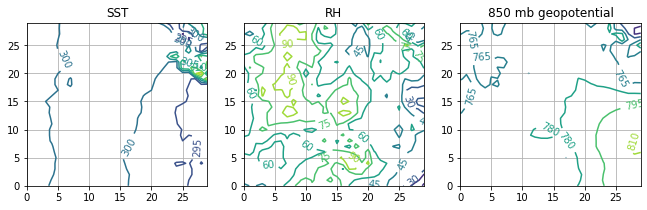

In [3]:
#
# visualize a few variables for checking the input data
#
print("Raw input data shape (nsample,nclass,ny,nx,nchannel) is: ",len(array_raw),len(array_raw[0]),
      len(array_raw[0][0]),len(array_raw[0][0][0]),len(array_raw[0][0][0][0]))

check_visualization = "yes"
if check_visualization== "yes":
    print("Plotting one example from raw data input")
    temp = np.array(array_raw[7][0])
    plt.figure(figsize=(11, 3)) 
    plt.subplot(1,3,1)
    CS = plt.contour(temp[:,:,4])
    plt.clabel(CS, inline=True, fontsize=10)
    plt.title('SST')
    plt.grid()

    plt.subplot(1,3,2)
    CS = plt.contour(temp[:,:,1])
    plt.clabel(CS, inline=True, fontsize=10)
    plt.title('RH')
    plt.grid()

    plt.subplot(1,3,3)
    CS = plt.contour(temp[:,:,9])
    plt.clabel(CS, inline=True, fontsize=10)
    plt.title('850 mb geopotential')
    plt.grid()

    plt.show()

In [4]:
#
# randomize data and generate training data (X,y)
#
import random
np.random.shuffle(array_raw)
X = []
y = []
for features,label in array_raw: 
    X.append(features)
    y.append(label)
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 12)
print(X.shape)
print(y)

(24, 30, 30, 12)
[1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1]


In [5]:
#
# save training data to an output for subsequent use
#
import pickle
pickle_out = open("tcg_X.pickle","wb")
pickle.dump(X, pickle_out)
pickle_out.close()
pickle_out = open("tcg_y.pickle","wb")
pickle.dump(y, pickle_out)
pickle_out.close()